# Test EC-CA3 heterosynaptic plasticity

Here we test the plasticity mechanism in our LIFNtwk class by ensuring that when we use physiological parameters (as specified in [parameters.ipynb](parameters.ipynb)) low rate spiking output in our CA3 cells yield no synaptic weight change in the EC-CA3 weights but tetanic spiking outputs yield very strong weight changes.

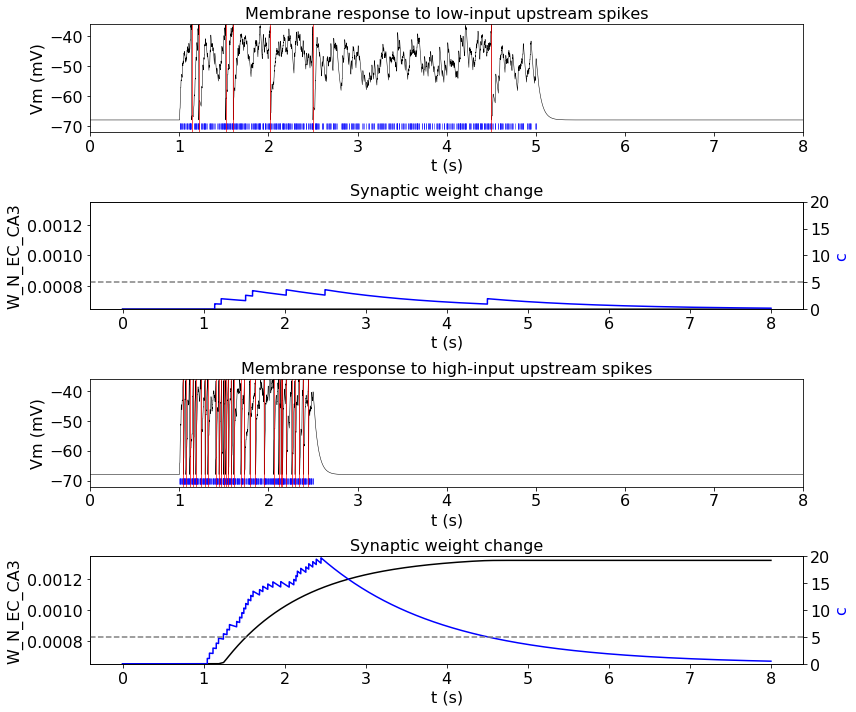

In [1]:
%reset -f
%matplotlib inline
import pdb
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
import plot

import PARAMETERS as P

R_PL_LOW = 150
R_PL_HIGH = 350

DUR = 8
SPKS_UP_LOW_START = 1
SPKS_UP_LOW_END = 5
SPKS_UP_HIGH_START = 1
SPKS_UP_HIGH_END = 2.5


np.random.seed(0)

# generate upstream input spike trains
ts = np.arange(0, DUR, P.DT)

spks_up_low_mask = (ts >= SPKS_UP_LOW_START) & (ts < SPKS_UP_LOW_END)

spks_up_low = np.zeros((len(ts), 2))
spks_up_low[spks_up_low_mask, 0] = np.random.poisson(R_PL_LOW*P.DT, spks_up_low_mask.sum())

spks_up_high_mask = (ts >= SPKS_UP_HIGH_START) & (ts < SPKS_UP_HIGH_END)

spks_up_high = np.zeros((len(ts), 2))
spks_up_high[spks_up_high_mask, 0] = np.random.poisson(R_PL_HIGH*P.DT, spks_up_high_mask.sum())

# make synaptic weight matrices
ws_rcr = {
    'AMPA': np.zeros((1, 1)),
    'NMDA': np.zeros((1, 1)),
}
ws_up = {
    'AMPA': np.array([[P.W_A_PL_CA3, 0]]),
    'NMDA': np.array([[0, P.W_N_EC_CA3_I]]),
}

# make masks for plastic weights
masks = {
    'AMPA': np.zeros((1, 2), dtype=bool),
    'NMDA': np.array([[False, True]]),
}
# make plasticity dict
plasticity = {
    'masks': masks,
    'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_EC_CA3_F},
    'T_W': P.T_W,
    'T_C': P.T_C,
    'C_S': P.C_S,
    'BETA_C': P.BETA_C,
}

# make ntwk
ES_REV = {'AMPA': P.E_AMPA, 'NMDA': P.E_NMDA}
TS_SYN = {'AMPA': P.T_AMPA, 'NMDA': P.T_AMPA}

ntwk = LIFNtwk(
    t_m=P.T_M, e_leak=P.E_LEAK, v_th=P.V_TH, v_reset=P.V_RESET, t_r=P.T_R,
    es_rev=ES_REV, ts_syn=TS_SYN, ws_rcr=ws_rcr, ws_up=ws_up,
    plasticity=plasticity)

# run simulation with low and high upstream spiking rates
vs_init = P.E_LEAK * np.ones(1)
gs_init = {'AMPA': np.zeros(1), 'NMDA': np.zeros(1)}

resp_low = ntwk.run(spks_up_low, vs_init, gs_init, P.DT)
resp_high = ntwk.run(spks_up_high, vs_init, gs_init, P.DT)

# plot voltage and spiking responses and plastic synaptic weight time-series
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True)
axs_twin = []

# low-input voltage
axs[0].plot(ts, 1000 * resp_low.vs[:, 0], color='k', lw=0.5)

# low-input upstream spikes
spk_ts_up_low = spks_up_low.nonzero()[0] * P.DT
axs[0].scatter(spk_ts_up_low, -70*np.ones(spk_ts_up_low.shape), marker='|', c='b', lw=0.5)

# low-input output spikes
for t_spk_out in resp_low.spks.nonzero()[0] * P.DT:
    axs[0].axvline(t_spk_out, color='r', lw=0.7)

axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylim(-72, 1000 * P.V_TH)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')
axs[0].set_title('Membrane response to low-input upstream spikes')

# low-input synaptic weight time-series
axs[1].plot(ts, resp_low.ws_plastic['NMDA'][:, 0], color='k')

axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylim(P.W_N_EC_CA3_I, P.W_N_EC_CA3_F)

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('W_N_EC_CA3')
axs[1].set_title('Synaptic weight change')

# spk-ctr auxiliary variable
axs_twin.append(axs[1].twinx())
axs_twin[0].plot(ts, resp_low.cs, color='b')
axs_twin[0].axhline(P.C_S, color='gray', ls='--')
axs_twin[0].set_ylim(0, 4*P.C_S)
axs_twin[0].set_ylabel('c', color='b')

# high-input voltage
axs[2].plot(ts, 1000 * resp_high.vs[:, 0], color='k', lw=0.5)

# high-input upstream spikes
spk_ts_up_high = spks_up_high.nonzero()[0] * P.DT
axs[2].scatter(spk_ts_up_high, -70*np.ones(spk_ts_up_high.shape), marker='|', c='b', lw=0.5)

# high-input output spikes
for t_spk_out in resp_high.spks.nonzero()[0] * P.DT:
    axs[2].axvline(t_spk_out, color='r', lw=0.7)
    
axs[2].set_xlim(ts[0], ts[-1])
axs[2].set_ylim(-72, 1000 * P.V_TH)
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('Vm (mV)')
axs[2].set_title('Membrane response to high-input upstream spikes')

# high-input synaptic weight time-series
axs[3].plot(ts, resp_high.ws_plastic['NMDA'][:, 0], color='k')

axs[3].set_xlim(ts[0], ts[-1])
axs[3].set_ylim(P.W_N_EC_CA3_I, P.W_N_EC_CA3_F)

axs[3].set_xlabel('t (s)')
axs[3].set_ylabel('W_N_EC_CA3')
axs[3].set_title('Synaptic weight change')

# spk-ctr auxiliary variable
axs_twin.append(axs[3].twinx())
axs_twin[1].plot(ts, resp_high.cs, color='b')
axs_twin[1].axhline(P.C_S, color='gray', ls='--')
axs_twin[1].set_ylim(0, 4*P.C_S)
axs_twin[1].set_ylabel('c', color='b')

for ax in list(axs) + axs_twin:
    plot.set_font_size(ax, 16)